In [1]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [2]:
import pandas as pd
from urlparse import urlparse
import tldextract
from collections import Counter
import jieba
import json
import math
import numpy as np
from time import time

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
model = KeyedVectors.load_word2vec_format('../data/w2v/huizhou_model_format_v1.bin', binary=False)

In [7]:
import fasttext
sk_model = fasttext.load_model('../data/fasttext/hz_sk_model.bin')

In [8]:
df = pd.read_csv('../data/final/huizhou-final-v2.csv')

In [9]:
df.info()

In [10]:
from urlparse import urlparse
df['domain']  = df.url.map(lambda x:tldextract.extract(x).domain + str('.') + tldextract.extract(x).suffix)

In [11]:
df = df[df['domain'] != 'huaxia.com']

In [12]:
import re
match = re.compile('([a-zA-Z_0-9_=_#_&_/])') #remove letters, numbers, and special characters in the article body
#match = re.compile('([a-zA-Z_0-9])') #remove all of english letters and numbers
def classifier_filters(s):
    return match.sub(r' ', s) 

In [13]:
def filter_combined(x):
    s = x.split()
    r = [t for t in s if (t.strip()) > 0 and t.strip() not in keyword_stop_words]
    t = ' '.join(r)
    ret = classifier_filters(t)
    #print 'before -----', t
    #print 'after ------', ret
    return ret   

In [14]:
huizhou_stop_words = [u'的', u'了', u'在', u'是', u'安徽', u'和', u'有', u'我', u'年', u'上', u'他', u'我们', u'及',
                      u'为', u'与', u'人', u'也', u'于', u'中', u'就', u'都', u'在线', u'等', u'不', u'网站', u'你', 
                      u'一个', u'到', u'之', u'对', u'说', u'进入', u'后', u'月', u'将', u'时', u'又', u'被', u'会员'
                     u'版权', u'论坛', u'以', u'而', u'着', u'下', u'这', u'但', u'要', u'或', u'首页', u'这', u'更',
                     u'地', u'从', u'卡', u'来', '多', u'日', u'她', u'还', u'联系', u'那', u'一处', u'一直', u'个', 
                     u'向', u'并', u'曾', u'这样', u'里', u'合肥', u'推荐', u'专栏', u'相关', u'当前', u'所有', u'中心'
                     u'频道', u'编辑', u'位置', u'第一', u'社区', u'看', '中安', u'安徽省', u'大', u'许可证', u'许可',
                     u'让', u'没有', u'什么', u'其', '请', '该', '用', '积分', u'凤阳', u'一篇', u'版权', u'县', u'这里',
                      u'就是', u'生于', u'他们', u'它', u'男', u'去', u'会', u'由', u'一', u'做', u'所', u'毕业', u'一种',
                     u'协会会员', u'把', u'能', u'至', u'这个', u'自己', u'黄山市', u'出', u'如', u'如',u'可以', u'很',
                     u'成为', u'好', u'先生', u'中国', u'集团', u'江淮', u'网', u'特色', u'全国', u'新', u'作为', u'师专',
                     u'则', u'重要', u'们', u'给', u'这些', u'过', u'安', u'最', u'现在', u'得', u'国家']

s = ' '.join(huizhou_stop_words)
#s = u'444 （）'

In [15]:
import unicodedata
def remove_non_chinese(s):
    r = [c for c in s if unicodedata.category(c).startswith('L')]
#print r
    return ''.join(r)
#print remove_non_chinese(s)

hz_dict = dict(zip(words, fq))

In [16]:
def ch_title_letters_removal(x):
    #print 'coming', x
    t = x.strip('  ')
    if(len(t)) == 0:
        return None
    
    if(len(x) > 0):
        #s = x.strip()
        s = remove_non_chinese(x)
        if len(s) > 0 and s not in huizhou_stop_words:
            return s.strip()
        else:
            return None
    return None

In [17]:
#calculate count using Counter
def map_document_word_cnt(x):
    n = 800
    del_cnt = 0
    count = Counter(x.decode('utf-8').split())
    top_n = count.most_common (n)
    words, cnt = zip(*top_n)
    for word in words:
        ret = ch_title_letters_removal(word)
        if ret == None or len(ret) == 0:
            del count[word]
            del_cnt +=1

    print 'deleted cnt', del_cnt
    top_n = count.most_common (200)
    return top_n

In [17]:
ret = map_document_word_cnt(df.iloc[2]['content_seg'])

for t in ret:
    print t[0], t[1]

In [177]:
top_n = count.most_common(400)
print dict(top_n)

In [18]:
global idx
idx = 0
def map_words_fq(x, normalize=True): 
    global idx
    print idx
    idx += 1
    s = x.decode('utf-8').split()
    #print 'vect ---', len(s), s
    ret = [ch_title_letters_removal(item) for item in s if len(item) > 0 and ch_title_letters_removal(item) != None]
    #print 'ret ---', ret, len(ret)
    count = Counter(ret)
    
    #print 'count', len(count)

    if len(count) > 1:
        top_N = count.most_common(100)
        
        words, cnt = zip(*top_N)
        tot = sum(cnt)
        hz_fq = [float(i)*1.0/tot for i in cnt]
        dictionary = dict(zip(words, hz_fq))
        
        #print 'going ---'
        #*words, cnt = zip(*top_200)
        #return dict(zip(words, cnt))
        return dictionary
    else:
        #print 'warning'
        return None

In [21]:
def map_word2vec_centroid(x):
    global model
    x = x.items() #dict to tuple
    # remove out-of-vocabulary words
    doc = [(word, fq) for word, fq in x if word in model.vocab]   
    if len(doc) == 0:
        #print x
        return None
    #words, fq = zip(*doc)
    ret = [model[x] * y for x, y in doc]
    
    val = np.mean(ret, axis=0)
    #print ret
    
    #doc = [word for word in doc if word in word2vec_model.vocab]
    return val

In [35]:
def map_ft_sk_centroid(x):
    global sk_model
    x = x.items() #dict to tuple
    # remove out-of-vocabulary words
    doc = [(word, fq) for word, fq in x if word in sk_model.words]   
    if len(doc) == 0:
        #print x
        return None
    #words, fq = zip(*doc)
    ret = [np.array(sk_model[x]) * y for x, y in doc]
    
    val = np.mean(ret, axis=0)
    #print ret
    
    #doc = [word for word in doc if word in word2vec_model.vocab]
    return val

In [36]:
def map_sk_cb_centroid(x):
    global cb_model
    x = x.items() #dict to tuple
    # remove out-of-vocabulary words
    doc = [(word, fq) for word, fq in x if word in cb_model.words]   
    if len(doc) == 0:
        #print x
        return None
    #words, fq = zip(*doc)
    ret = [np.array(cb_model[x]) * y for x, y in doc]
    
    val = np.mean(ret, axis=0)
    #print ret
    
    #doc = [word for word in doc if word in word2vec_model.vocab]
    return val

In [26]:
def map_unserialize (x, eval_val = False):
    #print '----- in'
    #print x
    d = dict()
    s = x.strip('{}')
    #s = s.strip('[]')
    ret = s.split(',')
    
    #print ret
    for t in ret:
        r = t.split(':')
        #print r[0], r[1]
        key = eval(r[0].decode('utf-8'))
        d[key] = float(r[1])
    #print len(ret)
    #print 'split -----'
    #print ' '.join(ret)
    return d

In [27]:
df.info()

In [28]:
t0 = time()
df['words_fq'] = df.content_seg.map(lambda x: map_words_fq(x))
#df['words_fq'] = df.s_vec.map(lambda x: map_unserialize(x))
print time() - t0 

In [29]:
df = df.dropna(subset =['words_fq'])

In [30]:
t0 = time()
df['w2v_centroid'] = df.words_fq.map(lambda x: map_word2vec_centroid(x))
time() - t0

28.701828002929688

In [37]:
t0 = time()
df['sk_centroid'] = df.words_fq.map(lambda x: map_ft_sk_centroid(x))
time() - t0

95.03109502792358

In [26]:
df.head(100)

,url,domain,title,content,content_seg,words_fq,w2v_centroid
0,http://cul.anhuinews.com/system/2016/11/28/007...,anhuinews.com,洪建华夫妇的竹刻人生,谁能想到，洪建华夫妇这对一无学历、二无家传、三无师承的“三无大师”成了省级非物质文化遗产·徽...,谁 能 想到 ， 洪 建华 夫妇 这 对 一 无 学历 、 二 无 家传 、 三无 师承 的...,"{u'艺术馆': 0.00445434298441, u'以来': 0.0066815144...","[-0.00344339, -0.00581077, 0.00216269, -0.0011..."
1,http://cul.anhuinews.com/system/2016/11/21/007...,anhuinews.com,徽州民歌传人操明花校园授艺,近日，省非物质文化遗产徽州民歌传承人操明花前往休宁县海阳二小、歙县城关小学和徽州区岩寺镇中心...,近日 ， 省非 物质 文化遗产 徽州 民歌 传承 人操 明花 前往 休宁县 海阳 二小 、 ...,"{u'传来': 0.00806451612903, u'小学': 0.00806451612...","[-0.00463216, 0.00496158, 0.00203924, 0.000965..."
2,http://cul.anhuinews.com/system/2016/11/03/007...,anhuinews.com,黄山楹联漫谈,黄山楹联第一人当推明朝诗人余绍祉。他遍历祖国名山大川，见到无数奇峰怪石，却感到抵不上黄山峰林...,黄山 楹联 第一 人当 推 明朝 诗人 余绍祉 。 他 遍历 祖国 名山大川 ， 见到 无数...,"{u'气派': 0.00763358778626, u'名句': 0.00763358778...","[-0.00371836, -0.00609779, 0.00594129, -0.0041..."
3,http://cul.anhuinews.com/system/2016/01/26/007...,anhuinews.com,徽派雕刻——徽州木雕艺术,徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,徽州 民居 、 家具 木板 和 圆木 雕刻 艺术 的 简称 。 木雕 在 旧属 徽州 各县 ...,"{u'吉祥图案': 0.0131578947368, u'少数': 0.0131578947...","[-0.0105879, -0.00692919, 0.00676165, -0.00754..."
4,http://cul.anhuinews.com/system/2016/01/26/007...,anhuinews.com,徽派雕刻——徽州砖雕艺术,徽州砖雕徽州砖雕的造型，来源于汉画象砖。汉画象砖大都是模印砖坯刻画后入密烧制，嵌窃时再进行修...,徽州 砖雕 徽州 砖雕 的 造型 ， 来源于 汉 画象 砖 。 汉 画象 砖 大都 是 模印...,"{u'要求': 0.00704225352113, u'厅': 0.007042253521...","[-0.00440875, -0.00674634, 0.00619312, -0.0053..."
5,http://cul.anhuinews.com/system/2016/01/26/007...,anhuinews.com,徽派雕刻——徽州石雕艺术,传统“徽州四雕”之一。在徽州城乡布很广，类别亦多，主要用于寺宅的廊柱、门墙、牌坊、墓葬等处的...,传统 “ 徽州 四雕 ” 之一 。 在 徽州 城乡 布 很 广 ， 类别 亦 多 ， 主要 ...,"{u'内': 0.00574712643678, u'旁有': 0.005747126436...","[-0.00890975, -0.00571684, 0.00625852, -0.0064..."
6,http://cul.anhuinews.com/system/2016/01/26/007...,anhuinews.com,徽州古民居雕刻装饰研究,徽州因明清两朝的繁盛而在历史上留下浓墨重彩的一笔，建筑就是那个时代的重要表现之一。当时的徽商...,徽州 因 明清 两朝 的 繁盛 而 在历史上 留下 浓墨重彩 的 一笔 ， 建筑 就是 那个...,"{u'三绝': 0.0045871559633, u'三回': 0.004587155963...","[-0.00875431, -0.00461302, 0.00975966, -0.0066..."
7,http://cul.anhuinews.com/system/2016/01/26/007...,anhuinews.com,徽派雕刻——忆千年沧桑，探秘西递牌楼,西递位于安徽省黄山市黟县城东8公里处，因地处古徽州府之西，曾设驿站“铺递所”而得名。作为唐李...,西递 位于 安徽省 黄山市 黟县 城东 8 公里 处 ， 因 地处 古 徽州 府 之西 ， ...,"{u'融入': 0.00444444444444, u'退': 0.004444444444...","[-0.00429807, -0.00572776, 0.00395334, -0.0065..."
8,http://cul.anhuinews.com/system/2014/07/16/006...,anhuinews.com,谭笔戏墨,文房四宝之一的毛笔品类中，宣笔自然是大名鼎鼎。可你知道吗，安徽还有一个地方的毛笔丝毫不亚于宣...,文房四宝 之一 的 毛笔 品类 中 ， 宣笔 自然 是 大名鼎鼎 。 可 你 知道 吗 ， ...,"{u'好几百年': 0.00666666666667, u'自然': 0.006666666...","[-0.00279577, -0.000962309, -0.00243313, -0.00..."
9,http://cul.anhuinews.com/system/2014/07/16/006...,anhuinews.com,飞虹横卧庐州城（二）,那时人们要想从大东门出城，必须要守城的兵勇放下吊桥，来来往往煞是费事。到了清朝晚期，李鸿章的...,那时 人们 要 想 从 大 东门 出 城 ， 必须 要 守城 的 兵勇 放下 吊桥 ， 来来...,"{u'买卖': 0.00793650793651, u'胞弟': 0.00793650793...","[-0.00264663, -0.0061449, -0.00528977, -0.0031..."


In [41]:
df['content_len'] = df['content'].str.len()

In [42]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline 

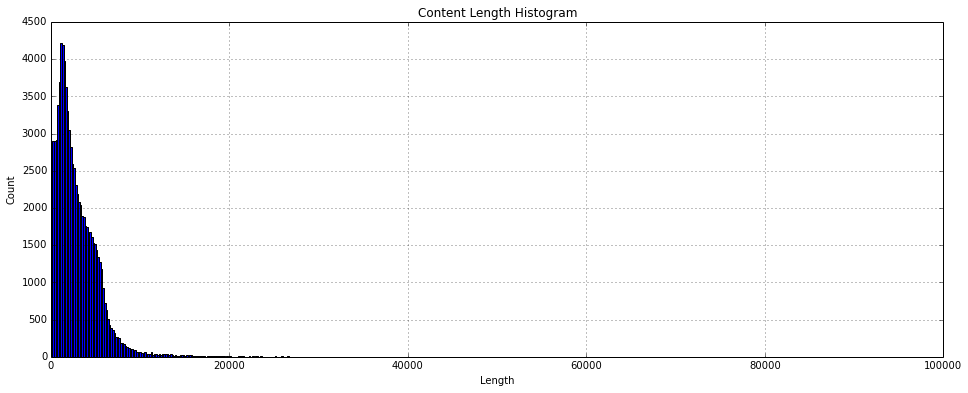

In [43]:
df['content_len'].hist(bins=500, figsize= (16, 6))
plt.title('Content Length Histogram')
plt.xlabel('Length')
plt.ylabel('Count')

In [44]:
test = df[df['content_len'] < 150]

In [45]:
test.info()

In [46]:
for t in test['content']:
    print t

In [47]:
df = df[df['content_len'] >= 150]

In [48]:
df.info()

In [49]:
def get_cosine2(vec1, vec2):
    
    sum1 = np.sum([vec1**2])
    sum2 = np.sum([vec2**2])
    numerator = np.sum([a*b for a,b in zip(vec1,vec2)])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [289]:
len(df.iloc[47075]['content'])

782

In [50]:
df.info()

In [51]:
docs = df['content_seg']

In [52]:
hz_words_fq = map_words_fq(' '.join(docs))

In [39]:
print ' '.join(hz_words_fq.keys())

In [53]:
t0 = time()
hz_vec = model[u'徽州']*0.3 + model[u'文化']*0.3 + model[u'徽文化']*0.4
df['hzwh_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

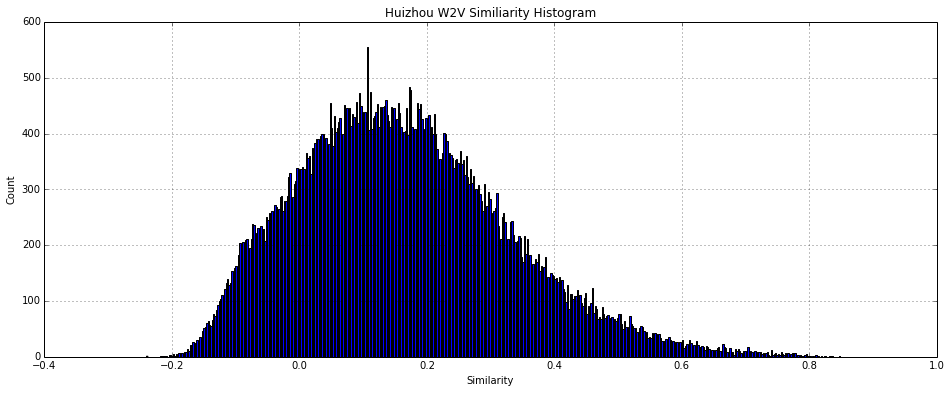

In [66]:
df['hzwh_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [54]:
hz_sim = df['hzwh_w2v_sim'].values.argsort()[::-1]

In [55]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzwh_w2v_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzwh_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [58]:
msk1 = df['content'].str.contains('徽州') 
msk2 = df['content'].str.contains('徽文化') 
msk = msk1 | msk2
df_check = df[msk]

In [59]:
df_check.info()

In [60]:
docs = df_check['content_seg']

In [61]:
hz_words_fq = map_words_fq(' '.join(docs))

In [62]:
print ' '.join(hz_words_fq.keys())

In [63]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [64]:
t0 = time()
df['dsi_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

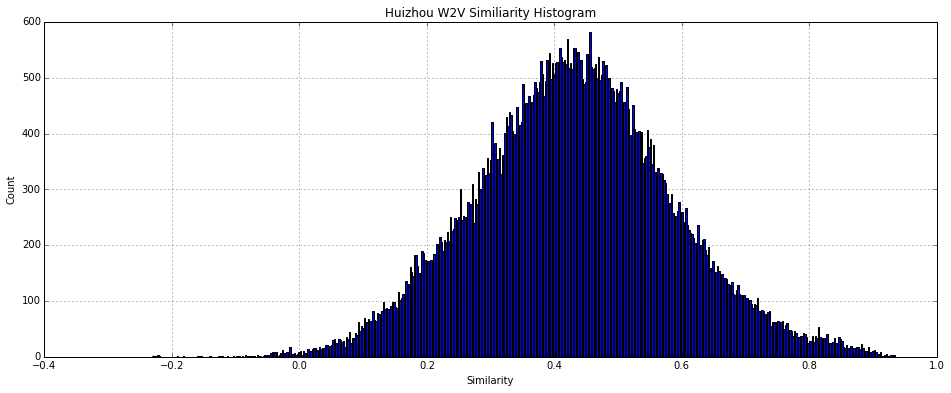

In [65]:
df['dsi_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [67]:
hz_sim = df['dsi_w2v_sim'].values.argsort()[::-1]

In [68]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['dsi_w2v_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['dsi_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [70]:
t0 = time()
hz_vec = np.array(sk_model[u'徽州'])*0.3 + np.array(sk_model[u'文化'])*0.3 + np.array(sk_model[u'徽文化'])*0.4
df['hzwh_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

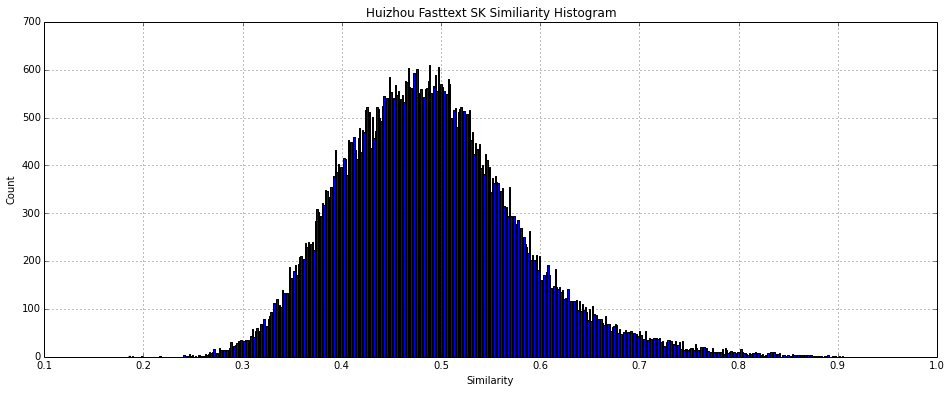

In [71]:
df['hzwh_sk_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou Fasttext SK Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [72]:
hz_sim = df['hzwh_sk_sim'].values.argsort()[::-1]

In [74]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzwh_sk_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzwh_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [75]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [76]:
t0 = time()
df['dsi_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

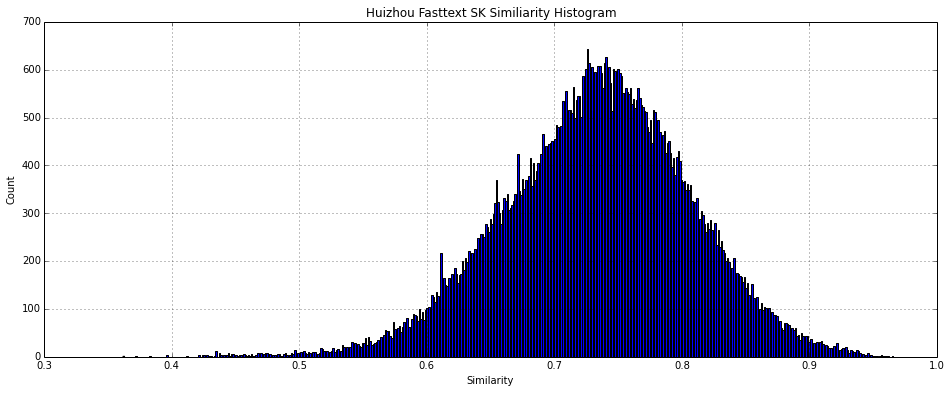

In [77]:
df['dsi_sk_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou Fasttext SK Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [78]:
hz_sim = df['dsi_sk_sim'].values.argsort()[::-1]

In [79]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['dsi_sk_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['dsi_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [59]:
type(model[u'徽州'])

numpy.ndarray

In [64]:
type(np.array(f_model['徽州']))

numpy.ndarray

In [80]:
t0 = time()
hz_vec = model[u'徽派']*0.5 + model[u'建筑']*0.5
df['hzjz_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [81]:
hz_sim = df['hzjz_w2v_sim'].values.argsort()[::-1]

In [83]:
df['hzjz_w2v_sim'].max()

0.83613564865291601

In [86]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzjz_w2v_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzjz_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [103]:
msk1 = df['content'].str.contains('徽派') 
msk2 = df['content'].str.contains('建筑') 
msk = msk1 | msk2
df_check = df[msk]

In [104]:
docs = df_check['content_seg']

In [105]:
hz_words_fq = map_words_fq(' '.join(docs))

In [106]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [107]:
t0 = time()
df['hzjz_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [108]:
hz_sim = df['hzjz_w2vs_sim'].values.argsort()[::-1]

In [109]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzjz_w2vs_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzjz_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [110]:
t0 = time()
hz_vec = np.array(sk_model[u'徽派'])*0.5 + np.array(sk_model[u'建筑'])*0.5
df['hzjz_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [111]:
hz_sim = df['hzjz_sk_sim'].values.argsort()[::-1]

In [112]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzjz_sk_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzjz_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [117]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [118]:
t0 = time()
df['hzjz_sks_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [119]:
hz_sim = df['hzjz_sks_sim'].values.argsort()[::-1]

In [120]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzjz_sks_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzjz_sks_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [121]:
t0 = time()
hz_vec = model[u'徽州']*0.4 + model[u'继承']*0.3 + model[u'遗产']*0.3
df['ycjc_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [122]:
df['ycjc_w2v_sim'].max()

0.87122242418664209

In [123]:
hz_sim = df['ycjc_w2v_sim'].values.argsort()[::-1]

In [125]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['ycjc_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['ycjc_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

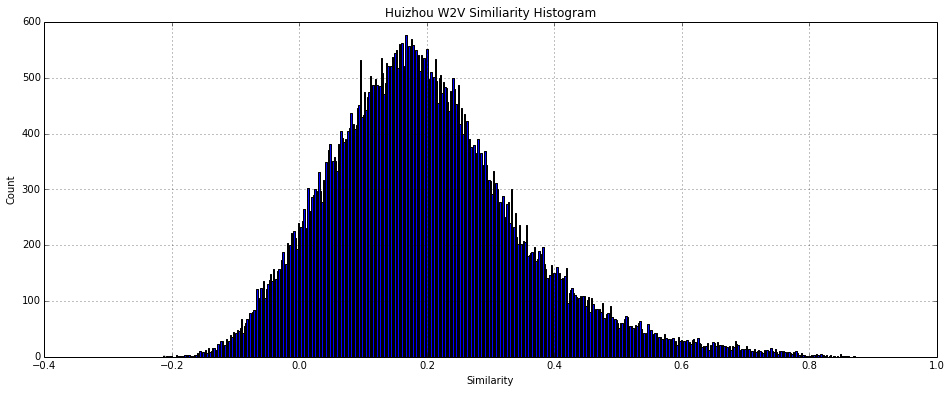

In [126]:
df['ycjc_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [127]:
msk1 = df['content'].str.contains('徽州') 
msk2 = df['content'].str.contains('继承') 
msk3 = df['content'].str.contains('遗产') 

msk = msk1 | msk2 | msk3
df_check = df[msk]

In [128]:
docs = df_check['content_seg']

In [130]:
hz_words_fq = map_words_fq(' '.join(docs))

In [131]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [132]:
t0 = time()
df['ycjc_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [133]:
hz_sim = df['ycjc_w2vs_sim'].values.argsort()[::-1]

In [134]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['ycjc_w2vs_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['ycjc_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [153]:
t0 = time()
hz_vec = np.array(sk_model[u'徽州'])*0.4 + np.array(sk_model[u'继承'])*0.3 + np.array(sk_model[u'遗产'])*0.3
df['ycjc_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [154]:
hz_sim = df['ycjc_sk_sim'].values.argsort()[::-1]

In [155]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['ycjc_sk_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['ycjc_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [138]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [139]:
t0 = time()
df['ycjc_sks_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [140]:
hz_sim = df['ycjc_sks_sim'].values.argsort()[::-1]

In [141]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['ycjc_sks_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['ycjc_sks_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [142]:
t0 = time()
hz_vec = model[u'徽州']*0.5 + model[u'雕刻']*0.5
df['hzdk_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [143]:
hz_sim = df['hzdk_w2v_sim'].values.argsort()[::-1]

In [144]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzdk_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzdk_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

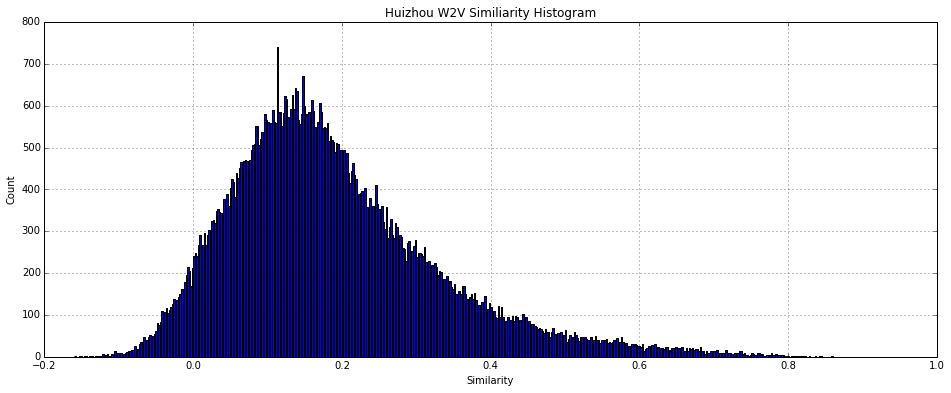

In [145]:
df['hzdk_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [146]:
msk1 = df['content'].str.contains('徽州') 
msk2 = df['content'].str.contains('雕刻') 

msk = msk1 | msk2
df_check = df[msk]

In [147]:
docs = df_check['content_seg']

In [148]:
hz_words_fq = map_words_fq(' '.join(docs))

In [149]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [150]:
t0 = time()
df['hzdk_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [151]:
hz_sim = df['hzdk_w2vs_sim'].values.argsort()[::-1]

In [152]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzdk_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzdk_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [156]:
t0 = time()
hz_vec = np.array(sk_model[u'徽州'])*0.5 + np.array(sk_model[u'雕刻'])*0.5 
df['hzdk_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [157]:
hz_sim = df['hzdk_sk_sim'].values.argsort()[::-1]

In [158]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzdk_sk_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzdk_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [159]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [160]:
t0 = time()
df['hzdk_sks_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [162]:
hz_sim = df['hzdk_sks_sim'].values.argsort()[::-1]

In [163]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzdk_sks_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzdk_sks_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [164]:
t0 = time()
hz_vec = model[u'徽派']*0.5 + model[u'艺术']*0.5
df['hpys_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [165]:
hz_sim = df['hpys_w2v_sim'].values.argsort()[::-1]

In [167]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hpys_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hpys_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [ ]:
df['hpys_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [168]:
msk1 = df['content'].str.contains('徽派') 
msk2 = df['content'].str.contains('艺术') 

msk = msk1 | msk2
df_check = df[msk]

In [169]:
docs = df_check['content_seg']

In [170]:
hz_words_fq = map_words_fq(' '.join(docs))

In [171]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [172]:
t0 = time()
df['hpys_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [173]:
hz_sim = df['hpys_w2vs_sim'].values.argsort()[::-1]

In [174]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hpys_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hpys_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [175]:
t0 = time()
hz_vec = np.array(sk_model[u'徽派'])*0.5 + np.array(sk_model[u'艺术'])*0.5 
df['hpys_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [176]:
hz_sim = df['hpys_sk_sim'].values.argsort()[::-1]

In [177]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hpys_sk_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hpys_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [178]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [179]:
t0 = time()
df['hpys_sks_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [180]:
hz_sim = df['hpys_sks_sim'].values.argsort()[::-1]

In [181]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hpys_sks_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hpys_sks_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [182]:
t0 = time()
hz_vec = model[u'徽剧']*0.5 + model[u'徽菜']*0.5
df['hjhc_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [183]:
hz_sim = df['hjhc_w2v_sim'].values.argsort()[::-1]

In [185]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hjhc_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hjhc_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

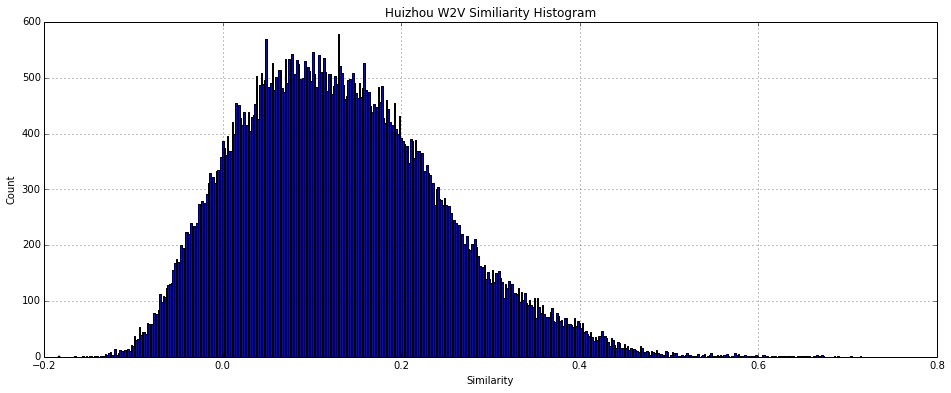

In [186]:
df['hjhc_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [187]:
msk1 = df['content'].str.contains('徽剧') 
msk2 = df['content'].str.contains('徽菜') 

msk = msk1 | msk2
df_check = df[msk]

In [188]:
docs = df_check['content_seg']

In [189]:
hz_words_fq = map_words_fq(' '.join(docs))

In [190]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [191]:
t0 = time()
df['hjhc_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [192]:
hz_sim = df['hjhc_w2vs_sim'].values.argsort()[::-1]

In [193]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hjhc_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hjhc_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [197]:
t0 = time()
hz_vec = np.array(sk_model[u'徽剧'])*0.5 + np.array(sk_model[u'徽菜'])*0.5 
df['hjhc_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [198]:
hz_sim = df['hjhc_sk_sim'].values.argsort()[::-1]

In [199]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hjhc_sk_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hjhc_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [200]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [201]:
t0 = time()
df['hjhc_sks_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [202]:
hz_sim = df['hjhc_sks_sim'].values.argsort()[::-1]

In [203]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hjhc_sks_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hjhc_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [204]:
t0 = time()
hz_vec = model[u'徽商']
df['hs_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [205]:
hz_sim = df['hs_w2v_sim'].values.argsort()[::-1]

In [208]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hs_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hs_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

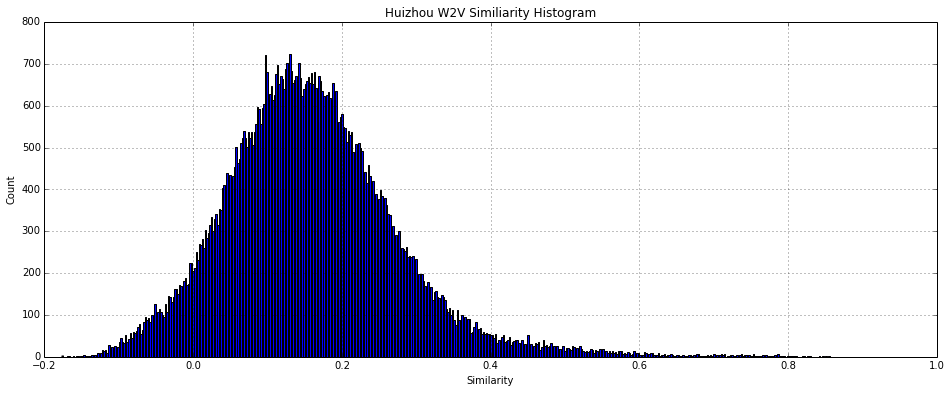

In [209]:
df['hs_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [210]:
msk1 = df['content'].str.contains('徽商') 

msk = msk1
df_check = df[msk]

In [211]:
docs = df_check['content_seg']

In [212]:
hz_words_fq = map_words_fq(' '.join(docs))

In [213]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [214]:
t0 = time()
df['hs_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [215]:
hz_sim = df['hs_w2vs_sim'].values.argsort()[::-1]

In [216]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hs_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hs_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [236]:
t0 = time()
hz_vec = np.array(sk_model[u'徽商']) 
df['hs_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [237]:
hz_sim = df['hs_sk_sim'].values.argsort()[::-1]

In [238]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hs_sk_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hs_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [220]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [221]:
t0 = time()
df['hs_sks_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [222]:
hz_sim = df['hs_sks_sim'].values.argsort()[::-1]

In [223]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hs_sks_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hs_sks_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [224]:
t0 = time()
hz_vec = model[u'新安']*0.5 + model[u'理学']*0.5
df['xalx_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [225]:
hz_sim = df['xalx_w2v_sim'].values.argsort()[::-1]

In [228]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['xalx_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['xalx_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

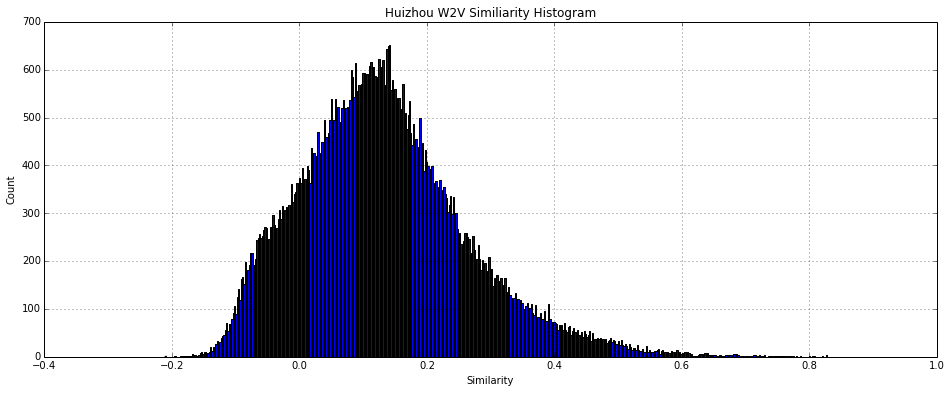

In [227]:
df['xalx_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [229]:
msk1 = df['content'].str.contains('新安') 
msk2 = df['content'].str.contains('理学') 

msk = msk1 | msk2
df_check = df[msk]

In [230]:
docs = df_check['content_seg']

In [231]:
hz_words_fq = map_words_fq(' '.join(docs))

In [232]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [233]:
t0 = time()
df['xalx_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [234]:
hz_sim = df['xalx_w2vs_sim'].values.argsort()[::-1]

In [235]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['xalx_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['xalx_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [266]:
t0 = time()
hz_vec = np.array(sk_model[u'新安'])*0.5 + np.array(sk_model[u'理学'])*0.5
df['xalx_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [241]:
hz_sim = df['xalx_sk_sim'].values.argsort()[::-1]

In [242]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['xalx_sk_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['xalx_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [243]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [267]:
t0 = time()
df['xalx_sks_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [245]:
hz_sim = df['xalx_sks_sim'].values.argsort()[::-1]

In [246]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['xalx_sks_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['xalx_sks_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [265]:
t0 = time()
hz_vec = model[u'徽学']*0.5 + model[u'研究']*0.5
df['hxyj_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [248]:
hz_sim = df['hxyj_w2v_sim'].values.argsort()[::-1]

In [251]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hxyj_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hxyj_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

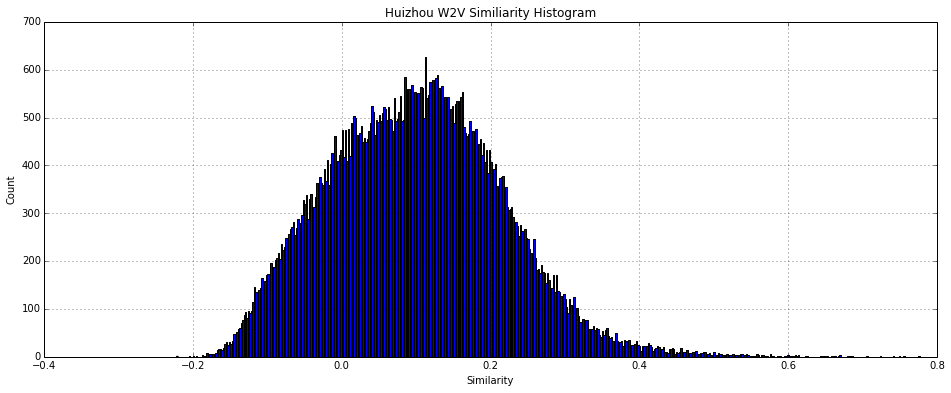

In [250]:
df['hxyj_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [252]:
msk1 = df['content'].str.contains('徽学') 
msk2 = df['content'].str.contains('研究') 

msk = msk1 | msk2
df_check = df[msk]

In [253]:
docs = df_check['content_seg']

In [254]:
hz_words_fq = map_words_fq(' '.join(docs))

In [255]:
hz_vec = map_word2vec_centroid(hz_words_fq)

In [257]:
t0 = time()
df['hxyj_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [258]:
hz_sim = df['hxyj_w2vs_sim'].values.argsort()[::-1]

In [259]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hxyj_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hxyj_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [268]:
t0 = time()
hz_vec = np.array(sk_model[u'徽学'])*0.5 + np.array(sk_model[u'研究'])*0.5
df['hxyj_sk_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [269]:
hz_sim = df['hxyj_sk_sim'].values.argsort()[::-1]

In [270]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hxyj_sk_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hxyj_sk_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [271]:
hz_vec = map_ft_sk_centroid(hz_words_fq)

In [272]:
t0 = time()
df['hxyj_sks_sim'] = df.sk_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [273]:
hz_sim = df['hxyj_sks_sim'].values.argsort()[::-1]

In [274]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hxyj_sks_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hxyj_sks_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [277]:
t0 = time()
hz_vec = model[u'许村']
df['check_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [278]:
hz_sim = df['check_w2v_sim'].values.argsort()[::-1]

In [280]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['check_w2v_sim'] > 0.50 and idx < 50:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['check_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [293]:
msk1 = df['content'].str.contains('许村') 

msk = msk1
df_check = df[msk]

In [294]:
df_check.info()

In [295]:
docs = df_check['content_seg']

In [296]:
hz_words_fq = map_words_fq(' '.join(docs))

In [298]:
print ' '.join(hz_words_fq.keys())

In [284]:
t0 = time()
df['check_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [285]:
hz_sim = df['check_w2v_sim'].values.argsort()[::-1]

In [286]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['check_w2v_sim'] > 0.50 and idx < 50:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['check_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [291]:
hz_sim = df_check['content_len'].values.argsort()[::-1]

In [292]:
idx = 0
for i in hz_sim:
    if df_check.iloc[i]['content_len'] > 0:
        title = df_check.iloc[i]['title']
        content = df_check.iloc[i]['content']
        sim_val = df_check.iloc[i]['content_len']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [299]:
import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [305]:
df_check['content_tb'] = df_check.content_seg.map(lambda x: tb(x.decode('utf-8')))

In [306]:
bloblist = df_check['content_tb']

In [309]:
for i, blob in enumerate(bloblist):
    print("Top words in document {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:3]:
        #print("\tWord: {}, TF-IDF: {}".format(word, round(score, 20)))
        print("\tWord: {}, TF-IDF: {}".format(word, score))        

KeyboardInterrupt: 

In [169]:
df.info()

In [168]:
df = df.drop_duplicates(['s_vec'])

In [158]:
def map_serialize(x):
    #print len(x)
    ret = []
    idx = 0
    for v in x:
        #print idx, v
        ret.append(str(v))
        idx += 1
    #print ret
    return ','.join(ret)

In [159]:
df['w2v_centroid_s'] = df.w2v_centroid.map(lambda x: map_serialize(x))

In [171]:
df.head()

,url,title,summary,content,content_seg,s_vec,domain,words_fq,w2v_centroid,content_len,...,hzwh_w2v_sim,hzjz_w2v_sim,ycjc_w2v_sim,hzdk_w2v_sim,hpys_w2v_sim,hjhc_w2v_sim,hs_w2v_sim,xalx_w2v_sim,hxyj_w2v_sim,w2v_centroid_s
0,http://cul.anhuinews.com/system/2016/11/28/007...,洪建华夫妇的竹刻人生,。不久前，我们几名政协委员应邀到正在建设中的黄山市徽派雕刻博物馆参观考察时，洪建华一边介绍新...,谁能想到，洪建华夫妇这对一无学历、二无家传、三无师承的“三无大师”成了省级非物质文化遗产·徽...,谁 能 想到 ， 洪 建华 夫妇 这 对 一 无 学历 、 二 无 家传 、 三无 师承 的...,"{u'竹木': 0.0114285714286, u'洪': 0.0571428571429...",anhuinews.com,"{u'竹木': 0.0114285714286, u'洪': 0.0571428571429...","[-0.0060236, -0.0103621, 0.00755846, -0.000569...",10703,...,0.463720,0.567314,0.573373,0.633446,0.680938,0.424617,0.311315,0.397321,0.291379,"-0.0060236,-0.0103621,0.00755846,-0.000569638,..."
1,http://cul.anhuinews.com/system/2016/11/21/007...,徽州民歌传人操明花校园授艺,。“磨米磨麦，磨米磨麦……”随着教室里传来一阵阵悦耳动听的方言民歌声，操明花正兴致勃勃地教同...,近日，省非物质文化遗产徽州民歌传承人操明花前往休宁县海阳二小、歙县城关小学和徽州区岩寺镇中心...,近日 ， 省非 物质 文化遗产 徽州 民歌 传承 人操 明花 前往 休宁县 海阳 二小 、 ...,"{u'它': 0.0123456790123, u'原生态': 0.012345679012...",anhuinews.com,"{u'它': 0.0123456790123, u'原生态': 0.012345679012...","[-0.0107781, 0.0129855, 0.00413211, 0.00171845...",1264,...,0.565720,0.358653,0.557331,0.468289,0.517698,0.438723,0.306038,0.308822,0.250730,"-0.0107781,0.0129855,0.00413211,0.00171845,-0...."
2,http://cul.anhuinews.com/system/2016/11/03/007...,黄山楹联漫谈,。黄山雄伟奇丽、气势非凡，原省文联主席赖少其说，非有大手笔，不能画黄山。有“二联”站得高，看...,黄山楹联第一人当推明朝诗人余绍祉。他遍历祖国名山大川，见到无数奇峰怪石，却感到抵不上黄山峰林...,黄山 楹联 第一 人当 推 明朝 诗人 余绍祉 。 他 遍历 祖国 名山大川 ， 见到 无数...,"{u'气派': 0.0123456790123, u'名句': 0.012345679012...",anhuinews.com,"{u'气派': 0.0123456790123, u'名句': 0.012345679012...","[-0.0120081, -0.0145887, 0.0144744, -0.0120817...",2028,...,0.255002,0.260202,0.269191,0.340901,0.296441,0.235815,0.191698,0.246864,0.182968,"-0.0120081,-0.0145887,0.0144744,-0.0120817,-0...."
3,http://cul.anhuinews.com/system/2016/01/26/007...,徽派雕刻——徽州木雕艺术,徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,徽州 民居 、 家具 木板 和 圆木 雕刻 艺术 的 简称 。 木雕 在 旧属 徽州 各县 ...,"{u'吉祥图案': 0.0172413793103, u'少数': 0.0172413793...",anhuinews.com,"{u'吉祥图案': 0.0172413793103, u'少数': 0.0172413793...","[-0.0134407, -0.0106611, 0.0100197, -0.0117281...",721,...,0.463754,0.588129,0.565690,0.765616,0.544592,0.325793,0.382593,0.354244,0.263324,"-0.0134407,-0.0106611,0.0100197,-0.0117281,-0...."
4,http://cul.anhuinews.com/system/2016/01/26/007...,徽派雕刻——徽州砖雕艺术,。从早期的简单粗犷、朴素的纹样，逐步演变到后期的繁腹、细致华丽的结构，形成了自己独特的艺术风...,徽州砖雕徽州砖雕的造型，来源于汉画象砖。汉画象砖大都是模印砖坯刻画后入密烧制，嵌窃时再进行修...,徽州 砖雕 徽州 砖雕 的 造型 ， 来源于 汉 画象 砖 。 汉 画象 砖 大都 是 模印...,"{u'一': 0.0106382978723, u'它': 0.0212765957447,...",anhuinews.com,"{u'一': 0.0106382978723, u'它': 0.0212765957447,...","[-0.0147771, -0.0149903, 0.0132143, -0.0146898...",2852,...,0.426712,0.555901,0.473556,0.605832,0.577255,0.312113,0.289483,0.315999,0.203333,"-0.0147771,-0.0149903,0.0132143,-0.0146898,-0...."


In [172]:
df.to_csv('../data/clean/huizhou_web_v1.csv', encoding='utf-8', index=False)

In [165]:
df_out = df[['url', 'title', 'summary', 'w2v_centroid_s', 'hzwh_w2v_sim', 'hzjz_w2v_sim', 'ycjc_w2v_sim', 'hzdk_w2v_sim',
             'hpys_w2v_sim', 'hjhc_w2v_sim', 'hs_w2v_sim', 'xalx_w2v_sim', 'hxyj_w2v_sim']]

In [166]:
df_out.to_csv('../data/clean/huizhou-web-slim_v2.csv', encoding='utf-8', index=False)

In [170]:
df_out.info()

In [211]:
df.info()

In [212]:
df_full_out = df[['url', 'title', 'summary', 's_vec_cnt', 'content', 'content_seg']]

In [213]:
df_full_out.to_csv('/Users/nhu2000/projects/SimilarSearch/data/clean/huizhou_full_v1.1.csv', encoding='utf-8', index=False)

In [173]:
model[u'许村']

array([ -7.58834004e-01,   6.37849987e-01,   2.37314200e+00,
         3.93233001e-01,  -2.31934994e-01,  -4.19292003e-01,
         2.77810004e-02,  -6.70256019e-01,   1.31282401e+00,
        -2.81661004e-01,   1.56625605e+00,   1.19458902e+00,
         9.28260028e-01,   2.15436292e+00,   3.43926013e-01,
         7.05360025e-02,   1.01993299e+00,   1.49849200e+00,
         1.05655801e+00,   6.64417982e-01,  -1.83514905e+00,
        -9.82640028e-01,  -4.84759986e-01,   3.44781011e-01,
         2.77079999e-01,   3.39015990e-01,  -2.10096002e-01,
         4.17811006e-01,  -1.15651500e+00,   7.45559990e-01,
         2.34702206e+00,   5.76422989e-01,  -9.99136984e-01,
        -2.25249410e+00,   1.89790297e+00,  -1.52401996e+00,
        -8.07019994e-02,   7.10281014e-01,   6.56597972e-01,
         5.92401981e-01,   8.31799954e-03,  -6.80337012e-01,
        -3.36429000e-01,   7.28859976e-02,  -7.02839017e-01,
        -1.14953303e+00,   2.14949799e+00,  -1.44978094e+00,
         2.21020997e-01,